In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kkoderr","key":"c8fe657fefa556576daebcb63aeea539"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d pankajkumar2002/places365

Dataset URL: https://www.kaggle.com/datasets/pankajkumar2002/places365
License(s): unknown


In [5]:
! unzip places365.zip

Streaming output truncated to the last 5000 lines.
  inflating: val_256/valid_samples/Places365_val_00011667.jpg  
  inflating: val_256/valid_samples/Places365_val_00011671.jpg  
  inflating: val_256/valid_samples/Places365_val_00011679.jpg  
  inflating: val_256/valid_samples/Places365_val_00011681.jpg  
  inflating: val_256/valid_samples/Places365_val_00011686.jpg  
  inflating: val_256/valid_samples/Places365_val_00011689.jpg  
  inflating: val_256/valid_samples/Places365_val_00011690.jpg  
  inflating: val_256/valid_samples/Places365_val_00011696.jpg  
  inflating: val_256/valid_samples/Places365_val_00011697.jpg  
  inflating: val_256/valid_samples/Places365_val_00011702.jpg  
  inflating: val_256/valid_samples/Places365_val_00011703.jpg  
  inflating: val_256/valid_samples/Places365_val_00011706.jpg  
  inflating: val_256/valid_samples/Places365_val_00011717.jpg  
  inflating: val_256/valid_samples/Places365_val_00011718.jpg  
  inflating: val_256/valid_samples/Places365_val_0001

In [6]:
import pandas as pd
import numpy as np
import os

In [7]:
main_folder = "val_256"
for subfolder in os.listdir(main_folder):
  current_csv_mapping = []
  for file in os.listdir(os.path.join(main_folder, subfolder)):
    current_csv_mapping.append(os.path.join(main_folder,subfolder,file))
  current_csv_mapping = pd.DataFrame(current_csv_mapping, columns=['img_path'])
  current_csv_mapping.to_csv(subfolder + ".csv")


In [65]:
train_df = pd.read_csv("train_samples.csv")
val_df = pd.read_csv("valid_samples.csv")

In [66]:
train_df = train_df['img_path']
val_df = val_df['img_path']

In [67]:
train_df.head()

,img_path
0,val_256/train_samples/Places365_val_00027738.jpg
1,val_256/train_samples/Places365_val_00027839.jpg
2,val_256/train_samples/Places365_val_00015490.jpg
3,val_256/train_samples/Places365_val_00033470.jpg
4,val_256/train_samples/Places365_val_00021702.jpg


In [68]:
train_df.shape

(21900,)

In [69]:
import cv2
from skimage.color import rgb2lab, lab2rgb

In [70]:
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img = rgb2lab(img)
    return (img[:,:,0]/100).reshape(256,256,1) , img[:,:,1:]/128.0

In [71]:
l_channel, ab_channel = load_image(train_df[1])
print(l_channel.shape)
print(ab_channel.shape)

(256, 256, 1)
(256, 256, 2)


In [72]:
ab_channel.min()

np.float64(-0.26683279734645204)

In [73]:
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Flatten, Dense, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [74]:
def GeneratorModel():
    input_layer = Input(shape=(256, 256, 1))  # Consider using 256x256 for perfect halving/doubling
    skips = []

    # Encoder
    x = Conv2D(64, (3,3), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skips.append(x)

    x = Conv2D(128, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skips.append(x)

    x = Conv2D(256, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skips.append(x)

    x = Conv2D(512, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skips.append(x)

    # Bottleneck
    x = Conv2D(512, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Decoder
    for filters in [512, 256, 128, 64]:
        x = Conv2DTranspose(filters, (3,3), strides=2, padding='same')(x)
        x = Concatenate()([x, skips.pop()])
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    # Final Upsample (to get back to 256x256)
    x = Conv2DTranspose(32, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Output
    output_layer = Conv2D(2, (3,3), activation='tanh', padding='same')(x)
    return Model(inputs=input_layer, outputs=output_layer)


In [75]:
g_model = GeneratorModel()
g_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_57      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │     73,856 │ leaky_re_lu_57[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_58      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,168 │ leaky_re_lu_58[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_59      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ leaky_re_lu_59[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_60      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ leaky_re_lu_60[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_61      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_20 │ (None, 16, 16,    │  2,359,808 │ leaky_re_lu_61[0… │
│ (Conv2DTranspose)   │ 512)              │            │                 

 Total params: 9,417,634 (35.93 MB)

 Trainable params: 9,410,786 (35.90 MB)

 Non-trainable params: 6,848 (26.75 KB)

In [76]:
def discriminatorModel():
    input_layer = Input((256, 256, 3))

    x = Conv2D(64, (3, 3), strides=2, padding='same')(input_layer)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)

    output_layer = Dense(1, activation='sigmoid')(x)

    return Model(inputs=input_layer, outputs=output_layer)


In [77]:
d_model = discriminatorModel()
d_model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_67 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_68 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_69 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,587,713 (6.06 MB)

 Trainable params: 1,585,793 (6.05 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [78]:
g_model.input.shape[1:]

(256, 256, 1)

In [79]:
def gan_model(g_model, d_model):
  #input layers
  l_channel_input_layer = Input(shape=(256,256,1))
  #generate fake 'ab' channels
  ab_fake_output_layer = g_model(l_channel_input_layer)

  discriminator_input_layer = Concatenate()([l_channel_input_layer, ab_fake_output_layer])
  output_layer = d_model(discriminator_input_layer)
  return Model(inputs=l_channel_input_layer, outputs=output_layer)

In [80]:
gan_model = gan_model(g_model, d_model)
gan_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_10       │ (None, 256, 256,  │  9,417,634 │ input_layer_13[0… │
│ (Functional)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 256, 256,  │          0 │ input_layer_13[0… │
│ (Concatenate)       │ 3)                │            │ functional_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_11       │ (None, 1)         │  1,587,713 │ concatenate_24[0… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,005,347 (41.98 MB)

 Trainable params: 10,996,579 (41.95 MB)

 Non-trainable params: 8,768 (34.25 KB)

In [81]:
def load_batch_images(df_image_path):
  batch_l_channel = []
  batch_ab_channel = []
  for img_path in df_image_path:
    l_channel, ab_channel = load_image(img_path)
    batch_l_channel.append(l_channel)
    batch_ab_channel.append(ab_channel)
  return np.array(batch_l_channel), np.array(batch_ab_channel)

In [89]:
def data_loader(df, batch_size):
  df = df.sample(frac=1).reset_index(drop=True)
  for i in range(df.shape[0]//batch_size):
    batch_df = df.iloc[i*batch_size:(i+1)*batch_size]
    l_channel, ab_channel = load_batch_images(batch_df)
    yield l_channel, ab_channel

In [90]:
from tensorflow.keras.optimizers import Adam

In [91]:
epochs = 20
batch_size = 64
total_batchs = train_df.shape[0]//batch_size
g_lr = 0.0001
d_lr = 0.0003
g_optimizer = Adam(learning_rate=g_lr, beta_1=0.5)
d_optimizer = Adam(learning_rate=d_lr, beta_1=0.5)

In [93]:
training_data_loader = data_loader(train_df, batch_size)

In [94]:
train_df.head()

,img_path
0,val_256/train_samples/Places365_val_00027738.jpg
1,val_256/train_samples/Places365_val_00027839.jpg
2,val_256/train_samples/Places365_val_00015490.jpg
3,val_256/train_samples/Places365_val_00033470.jpg
4,val_256/train_samples/Places365_val_00021702.jpg


In [95]:
data = next(training_data_loader)
data[1].shape

(64, 256, 256, 2)

In [96]:
validation_data_loader = data_loader(val_df, 4)

In [97]:
from matplotlib import pyplot as plt

In [98]:
def validate_training(validation_data_loader, g_model):
  data = next(validation_data_loader)
  l_channel = data[0]
  ab_channel = data[1] * 128.0
  fake_ab_channel = g_model.predict(l_channel, verbose=0) * 128.0
  l_channel = l_channel*100.0
  l_channel = np.clip(l_channel, 0, 100)
  ab_channel = np.clip(ab_channel, -128, 127)
  fake_ab_channel = np.clip(fake_ab_channel, -128, 127)
  real_images = np.concatenate((l_channel, ab_channel), axis=-1)
  generated_images = np.concatenate((l_channel, fake_ab_channel), axis=-1)
  fig, axes = plt.subplots(2,4,figsize=(4*4, 8))
  for idx in range(4):
    axes[0,idx].imshow(lab2rgb(real_images[idx]))
    axes[0,idx].axis('off')

    axes[1,idx].imshow(lab2rgb(generated_images[idx]))
    axes[1,idx].axis('off')
  plt.show()


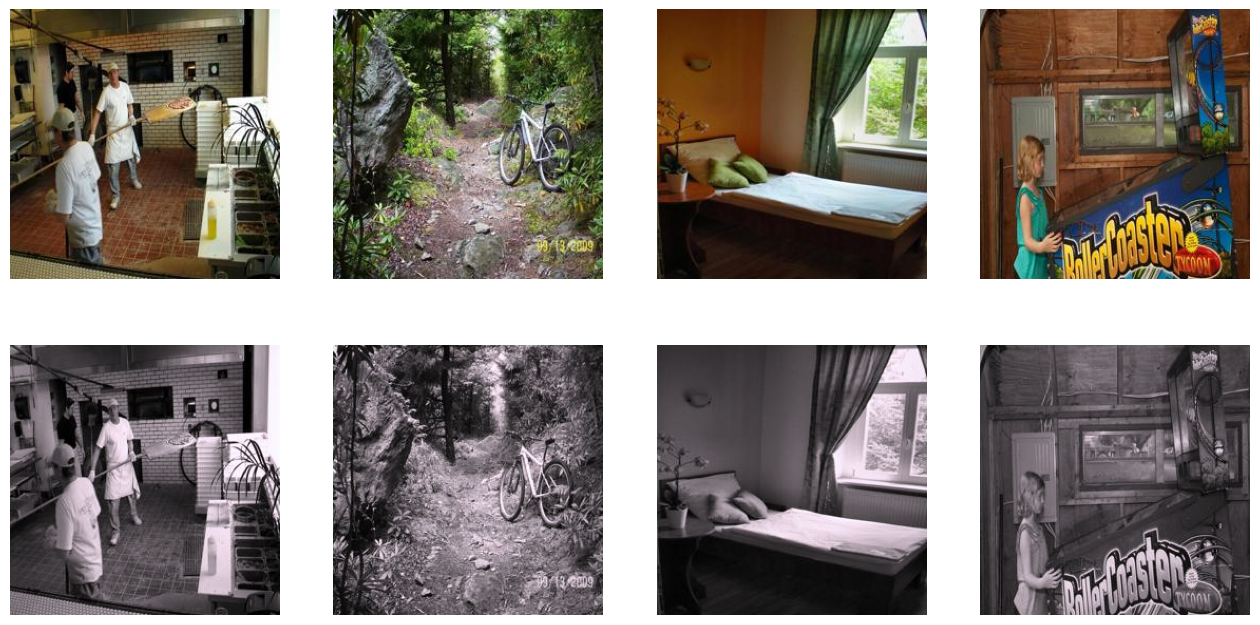

In [99]:
validate_training(validation_data_loader, g_model)

In [ ]:
from tensorflow import GradientTape
import tensorflow as tf

In [ ]:
def custom_gen_loss(real_ab, generated_ab, disc_generated_output):
  gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(real_ab - generated_ab))

  total_gen_loss = gan_loss + (100 * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def custom_disc_loss(disc_real_output, disc_generated_output):
  real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
for epoch in range(epochs):
  batch_no = 0
  for batch in training_data_loader:
    batch_no+=1
    with GradientTape() as gen_tape, GradientTape() as disc_tape:
      real_images = np.concatenate((batch[0], batch[1]), axis=-1)
      gen_output = g_model(batch[0], training=True)
      fake_images = np.concatenate((batch[0], gen_output), axis=-1)

      real_output = d_model(real_images, training=True)
      fake_output = d_model(fake_images, training=True)

      total_gen_loss, gan_loss, l1_loss = custom_gen_loss(batch[1], gen_output, fake_output)
      total_disc_loss = custom_disc_loss(real_output, fake_output)
      print(f"Epoch:{epoch+1} | Batch:{batch_no}/{total_batchs} | Total_d_loss:{total_disc_loss} | Total_g_loss:{total_gen_loss}")
    gradients_of_generator = gen_tape.gradient(total_gen_loss, g_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(total_disc_loss, d_model.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients_of_generator, g_model.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))
  if(epoch+1)%5==0:
    validate_training(validation_data_loader, g_model)


In [ ]:
import pickle as pkl

In [ ]:
pkl.dump(g_model, open('generator.pkl', 'wb'))